In [69]:
import pandas as pd
import numpy as np

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec

import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument

from sklearn.model_selection import KFold

from sklearn.base import clone as sklearn_clone

from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

import matplotlib.pyplot as plt

## Lodad data

In [12]:
df_topics = pd.read_csv('../datasets/ready2use/topics.csv', index_col=0)
df_topics.shape

(6541, 1)

In [21]:
df = pd.read_csv('../datasets/ready2use/fake_news_features_combined.csv', sep=';')

df = df[ df['assestment'] != 'brak' ]

df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

y_train = df.copy()['assestment'][df.index.isin(df_topics.index)]

X_train = pd.read_csv('../datasets/ready2use/words_clean_pl.csv', index_col=0)
X_train['words_clean'] = X_train['words_clean'].str.split(' ')

In [22]:
y_train.shape

(6541,)

In [23]:
X_train.shape

(6541, 1)

In [25]:
X_train.head()

,words_clean
1,"[bank, centralny, ukraina, walutowy, kwota, do..."
2,"[grudzień, mieć, trzeci, inflacja, unia, rekor..."
3,"[jedyny, ambasador, unia, czas, obecny, placów..."
4,"[prezes, nbp, adam, glapiński, odpowiedzialny,..."
5,"[narodowy, bank, zwiększać, zasób, odpowiadać,..."


In [46]:
train = X_train.copy()
train['label'] = y_train
train = train.dropna()
train.head()

,words_clean,label
1,"[bank, centralny, ukraina, walutowy, kwota, do...",1
2,"[grudzień, mieć, trzeci, inflacja, unia, rekor...",1
3,"[jedyny, ambasador, unia, czas, obecny, placów...",1
4,"[prezes, nbp, adam, glapiński, odpowiedzialny,...",0
5,"[narodowy, bank, zwiększać, zasób, odpowiadać,...",1


In [47]:
train.shape

(6532, 2)

In [48]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=r['words_clean'], tags=[r.label]), axis=1)

### Kfold

In [49]:
cv_fold = []
cv_fold_i = []

for i in df_topics['topic'].unique().reshape(10,-1):
    train_cv = df_topics.index[ ~np.isin(df_topics["topic"], i) ].values
    test_cv = df_topics.index[ np.isin(df_topics["topic"], i) ].values
    
    train_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], i) ].values
    test_cv_i = df_topics.reset_index().index[ np.isin(df_topics["topic"], i) ].values
    
    cv_fold.append( [train_cv, test_cv])
    cv_fold_i.append( [train_cv_i, test_cv_i])

In [50]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(df_topics)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(df_topics):
    train_cv = df_topics.iloc[ train_index, : ].index.values
    test_cv = df_topics.iloc[ test_index, : ].index.values

    train_cv_i= df_topics.reset_index().iloc[ train_index, : ].index.values
    test_cv_i = df_topics.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, test_cv])
    cv_Kfold_i.append( [train_cv_i, test_cv_i])

## Experiments

In [51]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

In [52]:
import multiprocessing
cores = multiprocessing.cpu_count() - 1
cores

15

In [79]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

In [164]:
def run_experiment_d2v(X, cv, clf_org):

    results = {
        'test_accuracy' : [],
        'test_precision' : [],
        'test_recall' : [],
        'test_f1' : []
    }

    c_matrix = np.zeros((2,2))

    for train_cv, test_cv in tqdm(cv):
        clf = sklearn_clone(clf_org)

        train_tagged_dov2vec = X[X.index.isin(train_cv)]
                
        
        model_dbow = Doc2Vec(dm=0, workers=cores, vector_size=100, window=5,
                             seed=111)
        model_dbow.build_vocab([x for x in train_tagged_dov2vec.values])
        
        for epoch in range(30):
            model_dbow.train(utils.shuffle([x for x in train_tagged_dov2vec.values]), 
                             total_examples=len(train_tagged_dov2vec.values), epochs=1)
            model_dbow.alpha -= 0.002
            model_dbow.min_alpha = model_dbow.alpha
            
        
        model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=100, window=5,
                            seed=111)
        model_dmm.build_vocab([x for x in train_tagged_dov2vec.values])
        
        for epoch in range(30):
            model_dmm.train(utils.shuffle([x for x in train_tagged_dov2vec.values]), 
                            total_examples=len(train_tagged_dov2vec.values), epochs=1)
            model_dmm.alpha -= 0.002
            model_dmm.min_alpha = model_dmm.alpha
        
        
        new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
        
        y_train_t, X_train_t = get_vectors(new_model, X[X.index.isin(train_cv)])
        y_test_t, X_test_t = get_vectors(new_model, X[X.index.isin(test_cv)])
        
        
        clf.fit(X_train_t, y_train_t)

        y_pred = clf.predict(X_test_t)
        
        confusion = confusion_matrix(y_test_t, y_pred)
        c_matrix += confusion

        results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
        results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
        results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
        results['test_f1'].append( f1_score(y_test_t, y_pred) ) 
        

    metrics = {
        "Accuracy": np.array(results['test_accuracy']),
    #     "Precision": np.array(results['test_precision']).mean(),
    #     "Recall": np.array(results['test_recall']).mean(),
        "F1 Score":  np.array(results['test_f1']),
        }

    return metrics

In [166]:
out = run_experiment_d2v(train_tagged, cv_fold, clf_lr_1)
print(
    'doc2vec lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

100%|███████████████████████████████████████████| 10/10 [02:14<00:00, 13.45s/it]

doc2vec lr C1 Accuracy 0.598+-0.021 F1 Score 0.548+-0.040  0.598+-0.021 | 0.548+-0.040


In [165]:
out = run_experiment_d2v(train_tagged, cv_Kfold, clf_lr_1)
print(
    'doc2vec lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

100%|███████████████████████████████████████████| 10/10 [02:07<00:00, 12.71s/it]

doc2vec lr C1 Accuracy 0.605+-0.019 F1 Score 0.566+-0.028  0.605+-0.019 | 0.566+-0.028


### trying to visualise the results

In [102]:
import umap  # pip install umap-learn

In [172]:
X = train_tagged

for train_cv, test_cv in tqdm(cv_Kfold):
    train_tagged_dov2vec = X[X.index.isin(train_cv)]

    
    model_dbow = Doc2Vec(dm=0, workers=cores, vector_size=100, window=5,
                             seed=111)
    model_dbow.build_vocab([x for x in train_tagged_dov2vec.values])

    for epoch in range(30):
        model_dbow.train(utils.shuffle([x for x in train_tagged_dov2vec.values]), 
                         total_examples=len(train_tagged_dov2vec.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha


    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=100, window=5,
                        seed=111)
    model_dmm.build_vocab([x for x in train_tagged_dov2vec.values])

    for epoch in range(30):
        model_dmm.train(utils.shuffle([x for x in train_tagged_dov2vec.values]), 
                        total_examples=len(train_tagged_dov2vec.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha

    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

    
    y_train_t, X_train_t = get_vectors(new_model, X[X.index.isin(train_cv)])
    y_test_t, X_test_t = get_vectors(new_model, X[X.index.isin(test_cv)])
    
    break

  0%|                                                    | 0/10 [00:13<?, ?it/s]


In [173]:
manifold = umap.UMAP().fit(X_train_t, y_train_t)
X_reduced = manifold.transform(X_train_t)

In [174]:
X_reduced_test = manifold.transform(X_test_t)

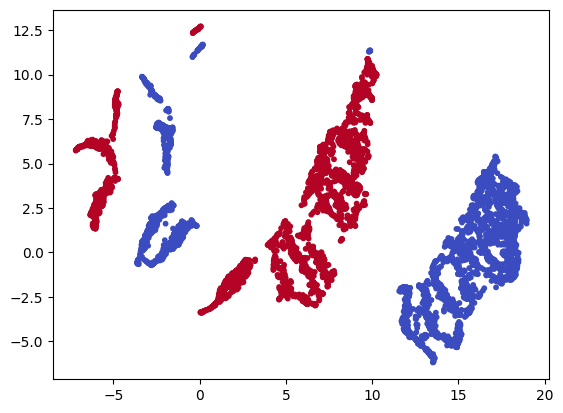

In [175]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train_t, s=10, cmap='coolwarm')

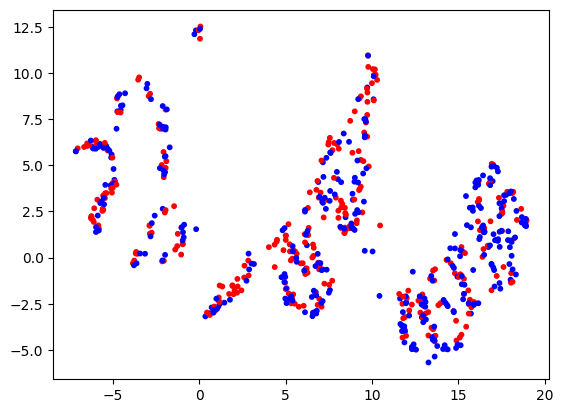

In [176]:
plt.scatter(X_reduced_test[:, 0], X_reduced_test[:, 1], c=y_test_t, s=10, cmap='bwr')